<a href="https://colab.research.google.com/github/Tooluloope/Transfer-Learning/blob/master/Transfer_Learning_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456,0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

You can download the dataset [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [0]:
# Authenticate and create the PyDrive client.
from google.colab import auth
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1wOs4EAz4N_L0cINemcwObMoyUvRr-Xlf'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('hymenoptera_data.zip')
!unzip hymenoptera_data.zip



In [0]:
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle=True, num_workers = 4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

4
yes


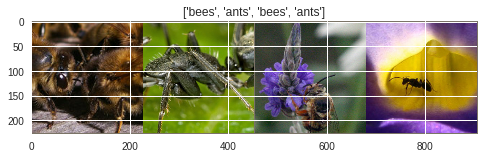

In [24]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.size(0))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion,optimizer, scheduler, num_epochs=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    
    for phase in ['train','val']:
      if phase == 'train':
        scheduler.step()
        model.train()
      else:
        model.eval()
      running_loss = 0.0
      running_corrects = 0
      
      
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _,preds = torch.max(outputs,1)
          loss = criterion(outputs, labels)
          
          if phase == 'train':
            loss.backward()
            optimizer.step()
            
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
      if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [30]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7435 Acc: 0.6148
val Loss: 0.1688 Acc: 0.9216
Epoch 1/24
----------
train Loss: 0.4204 Acc: 0.8156
val Loss: 0.2404 Acc: 0.9020
Epoch 2/24
----------
train Loss: 0.8090 Acc: 0.7295
val Loss: 0.4279 Acc: 0.8758
Epoch 3/24
----------
train Loss: 0.4749 Acc: 0.8279
val Loss: 0.2896 Acc: 0.9085
Epoch 4/24
----------
train Loss: 0.5136 Acc: 0.8115
val Loss: 0.6436 Acc: 0.7908
Epoch 5/24
----------
train Loss: 0.7085 Acc: 0.7787
val Loss: 0.4139 Acc: 0.8627
Epoch 6/24
----------
train Loss: 0.4973 Acc: 0.8115
val Loss: 0.5179 Acc: 0.8431
Epoch 7/24
----------
train Loss: 0.3684 Acc: 0.8443
val Loss: 0.3877 Acc: 0.8627
Epoch 8/24
----------
train Loss: 0.3503 Acc: 0.8566
val Loss: 0.3004 Acc: 0.8954
Epoch 9/24
----------
train Loss: 0.3787 Acc: 0.8566
val Loss: 0.2463 Acc: 0.9150
Epoch 10/24
----------
train Loss: 0.3197 Acc: 0.8689
val Loss: 0.2430 Acc: 0.9020
Epoch 11/24
----------
train Loss: 0.3412 Acc: 0.8525
val Loss: 0.2826 Acc: 0.8954
Epoch 12/24
--

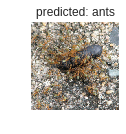

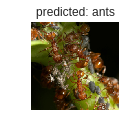

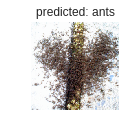

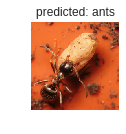

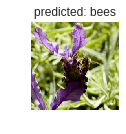

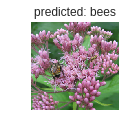

In [32]:
visualize_model(model_ft)


In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [34]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6502 Acc: 0.6352
val Loss: 0.4116 Acc: 0.7908
Epoch 1/24
----------
train Loss: 0.5322 Acc: 0.7664
val Loss: 0.2790 Acc: 0.8693
Epoch 2/24
----------
train Loss: 0.4480 Acc: 0.8156
val Loss: 0.2074 Acc: 0.9412
Epoch 3/24
----------
train Loss: 0.4855 Acc: 0.7869
val Loss: 0.1740 Acc: 0.9412
Epoch 4/24
----------
train Loss: 0.4662 Acc: 0.8074
val Loss: 0.2126 Acc: 0.9346
Epoch 5/24
----------
train Loss: 0.6566 Acc: 0.7541
val Loss: 0.1810 Acc: 0.9477
Epoch 6/24
----------
train Loss: 0.4561 Acc: 0.8197
val Loss: 0.2006 Acc: 0.9412
Epoch 7/24
----------
train Loss: 0.2486 Acc: 0.8811
val Loss: 0.2127 Acc: 0.9281
Epoch 8/24
----------
train Loss: 0.3943 Acc: 0.8115
val Loss: 0.1853 Acc: 0.9346
Epoch 9/24
----------
train Loss: 0.3548 Acc: 0.8074
val Loss: 0.2080 Acc: 0.9346
Epoch 10/24
----------
train Loss: 0.3872 Acc: 0.8197
val Loss: 0.1913 Acc: 0.9346
Epoch 11/24
----------
train Loss: 0.3281 Acc: 0.8525
val Loss: 0.1896 Acc: 0.9346
Epoch 12/24
--